# Making an animated heatmap

We will use maximum temperature data from the [Cal-Adapt API](http://beta.cal-adapt.org/data/api/) 

In [1]:
# A 'magic' command that displays plots inline inside the notebook as static images.
# The second magin commands seems to be required for animations
%matplotlib inline
%matplotlib nbagg

try:
    import requests 
    import json
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
except ImportError:
    print('Some required Python modules are missing.')
    
# Setting headers for HTTP request, Cal-Adapt API provides data in json, csv, geotiff formats. We will use json.
headers = {'ContentType': 'json'}

# entry point of the API
api = 'http://api.cal-adapt.org/api'

### Let's look at data for Sacramento County

If you open [this link](http://api.cal-adapt.org/api/), you can see a list of resources currently available through the api. The list of climate datasets is under `series`. You can pass in your own geometry to query the climate data or use geometry available through the api. For this exercise we will use the `counties` resource available through the Cal-Adapt api. 

The code below gets the `id` for the polygon feature (Sacramento County) by querying the `counties` resource.

In [2]:
feature_resource = 'counties'
feature = None

# Point location (within Sacramento County) in geojson format
coord = (-121.4687, 38.5938)
point = '{"type":"Point","coordinates":[%s,%s]}' % coord

# Params
params = {'intersects': point, 'srs': 4326, 'precision': 4}

# Construct url
url = '%s/%s/' % (api, resource)

# Get county geometry from api
# Construct a uri string which we will pass to the api later
try:
    response = requests.get(url, params, headers=headers)
    print(response.url)
    print()
    json = response.json()
    feature = json['features'][0]
    print(feature)
except requests.exceptions.HTTPError as err:
    print (err)

http://api.cal-adapt.org/api/counties/?intersects={"type":"Point","coordinates":[-121.4687,38.5938]}&srs=4326&precision=4



### Get a list of all annual timeseries from Cal-Adapt API for maximum temperature for HadGEM2-ES model

Below we are searching the api to get a list of annual timeseries

In [3]:
resource = 'series'

# Params
search_str = 'yearly+average+maximum+temperature+HadGEM2-ES'
params = {'name': search_str, 'pagesize': 100}

# Construct url for finding list of series
url = '%s/%s/' % (api, resource)
timeseries = None

# Get list
try:
    response = requests.get(url, params, headers=headers)
    json = response.json()
    timeseries = json['results']
    for item in timeseries:
        print(item['url'])
except requests.exceptions.HTTPError as err:
    print (err)
    sys.exit(1)

http://api.cal-adapt.org/api/series/tasmax_year_HadGEM2-ES_historical/
http://api.cal-adapt.org/api/series/tasmax_year_HadGEM2-ES_rcp45/
http://api.cal-adapt.org/api/series/tasmax_year_HadGEM2-ES_rcp85/


Find timeseries for RCP 8.5 scenario

In [4]:
ts = [x for x in timeseries if (x['name'].find('8.5') > -1)]
ts_rcp85 = ts[0]

### Get Maximum Temperature data for HadGEM2-ES model for RCP 8.5 scenario

Setup parameters

In [5]:
# One way to pass in geometry to Cal-Adapt api is to use the ref parameter
ref = '/api/%s/%s/' % (feature_resource, feature['id'])
print('Uniform Resource Identifier for county: %s' % ref)

# Another way to pass in geometry is to use the g param with spatial boundary in geojson/WKT format.
# For this exercise we will not use this param
g = feature['geometry']

Uniform Resource Identifier for county: /api/counties/34/


In [6]:
# Period
startYear = 1961
endYear = 1990
period = str(startYear) + '-01-01/' + str(endYear) + '-12-31'
period = '%s-01-01/%s-12-31' % (startYear, endYear)

# Alternatively get complete timeseries and filter dates later on
period = 'rasters'

In [7]:
# Pagesize - number of records returned, default is 10
pagesize = 100

The downscaled climate model data in Cal-Adapt has a resolution of aproximately 6 km. So within a county there are multiple 6 km x 6 km grid cells. 

**For this exercise, we want the values for each grid cell within the county to make a raster animation. So we will not spatially aggregate the data.**

In [8]:
# Spatial aggregation
# stat = 'mean'

In [9]:
# Create params string to pass to api
params = {'pagesize': pagesize, 'ref': ref}

In [10]:
# Construct request
url = ts_rcp85['url'] + period

# Variable to store dataframe
data = None
    
try:
    response = requests.get(url, params, headers=headers)
    json = response.json()
    data = json['results']
except requests.exceptions.HTTPError as err:
    print (err)

### Create pandas dataframe from data.

In [11]:
df = pd.DataFrame(data)

# Change format of `event` field from string to datetime
df['event'] = pd.to_datetime(df['event'], format='%Y-%m-%d')

# Set event field as index
df = df.set_index(['event'])

# Print first 5 rows
df.head()

,geom,height,id,image,maxval,minval,name,nodata,slug,srs,tileurl,units,url,width,xpixsize,ypixsize
event,,,,,,,,,,,,,,,,
2006-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12320,"[[None, None, None, 297.54901123046875, 297.40...",306.680267,277.294617,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2006,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2007-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12321,"[[None, None, None, 299.23675537109375, 299.11...",306.515289,279.461761,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2007,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2008-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12322,"[[None, None, None, 297.712158203125, 297.6103...",306.392303,277.135956,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2008,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2009-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12323,"[[None, None, None, 297.7378845214844, 297.649...",306.001038,277.822418,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2009,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625
2010-01-01,"{'type': 'Polygon', 'coordinates': [[[-124.562...",195,12324,"[[None, None, None, 297.0587158203125, 296.957...",305.385651,277.153900,yearly average maximum temperature HadGEM2-ES ...,1.000000e+30,tasmax_year_HadGEM2-ES_rcp85_2010,"GEOGCS[""WGS 84"",DATUM[""WGS_1984"",SPHEROID[""WGS...",http://api.cal-adapt.org/tiles/tasmax_year_Had...,K,http://api.cal-adapt.org/api/rstores/tasmax_ye...,179,0.0625,-0.0625


The `image` field now has a list of lists (corresponding to rows and cols).

In [12]:
# Print first row of dataframe
df['image'].iloc[0]

[[None,
  None,
  None,
  297.54901123046875,
  297.4054260253906,
  297.38153076171875,
  297.3214111328125,
  297.3660888671875,
  297.3605041503906,
  297.50689697265625,
  297.37823486328125,
  297.1661682128906,
  297.11669921875,
  None],
 [None,
  None,
  None,
  297.4867858886719,
  297.3352355957031,
  297.2320251464844,
  297.2207336425781,
  297.1967468261719,
  297.2304992675781,
  297.2887268066406,
  297.3641052246094,
  297.3287048339844,
  296.9217529296875,
  None],
 [None,
  None,
  None,
  None,
  297.1847229003906,
  297.02294921875,
  297.0770568847656,
  297.1314697265625,
  297.1186218261719,
  297.22247314453125,
  297.1927185058594,
  297.21893310546875,
  297.28045654296875,
  297.2366943359375],
 [None,
  None,
  None,
  None,
  296.927734375,
  296.77081298828125,
  296.8077697753906,
  297.1183166503906,
  297.0250244140625,
  296.9697265625,
  297.0955505371094,
  297.285888671875,
  297.41668701171875,
  297.50006103515625],
 [None,
  None,
  None,
  None

Convert the format of the field from list to numpy array of floats.

In [13]:
df['image'] = df['image'].apply(lambda x: np.array(x, dtype=np.float))

# To check data type for a column
#type(df['image'].iloc[0])

# Print first row
df['image'].iloc[0]

array([[          nan,           nan,           nan,  297.54901123,
         297.40542603,  297.38153076,  297.32141113,  297.36608887,
         297.36050415,  297.50689697,  297.37823486,  297.16616821,
         297.11669922,           nan],
       [          nan,           nan,           nan,  297.48678589,
         297.3352356 ,  297.23202515,  297.22073364,  297.19674683,
         297.23049927,  297.28872681,  297.36410522,  297.32870483,
         296.92175293,           nan],
       [          nan,           nan,           nan,           nan,
         297.1847229 ,  297.02294922,  297.07705688,  297.13146973,
         297.11862183,  297.22247314,  297.19271851,  297.21893311,
         297.28045654,  297.23669434],
       [          nan,           nan,           nan,           nan,
         296.92773438,  296.77081299,  296.80776978,  297.11831665,
         297.02502441,  296.96972656,  297.09555054,  297.28588867,
         297.41668701,  297.50006104],
       [          nan,      

### Plot a heatmap for 1 year

In [14]:
# Find min and max values of the data. We will use these to anchor the colors for the heatmap.
# Since the data for image field for each row, is now a numpy array and not a single value, 
# we need to jump through some hoops to find the min and max of this subset of data.
calc_min = lambda x: np.nanmin(x) 
min_list = df['image'].apply(calc_min)
data_min = min(min_list)

calc_max = lambda x: np.nanmax(x) 
max_list = df['image'].apply(calc_max)
data_max = max(max_list)

print(data_min, data_max)

295.991790771 304.449584961


<IPython.core.display.Javascript object>


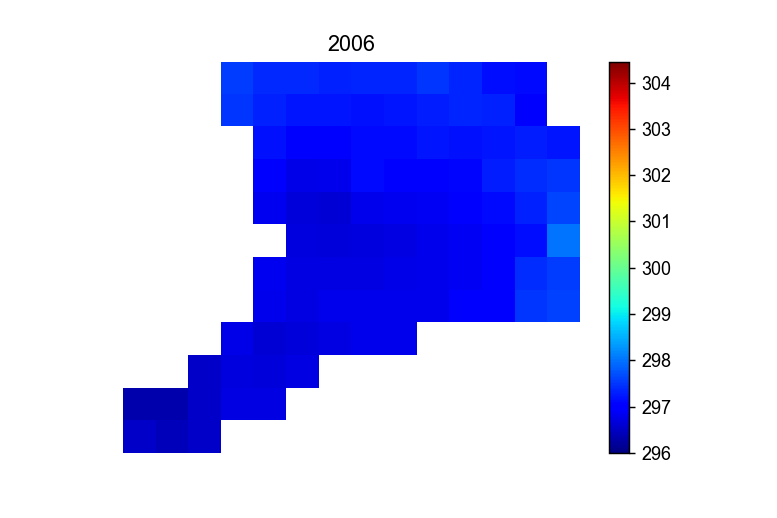

In [15]:
# Create a heatmap for 1 year with matplotlib
array = df['image'].iloc[0]
fig, ax = plt.subplots()
img = ax.imshow(
    array, 
    interpolation='nearest', 
    cmap=plt.get_cmap('jet'), 
    vmin=data_min, 
    vmax=data_max
)
fig.colorbar(img)
plt.axis('off')
plt.title(df.index[0].year)
plt.show()

Introducing [seaborn](http://seaborn.pydata.org/index.html). Seaborn is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics.

<IPython.core.display.Javascript object>


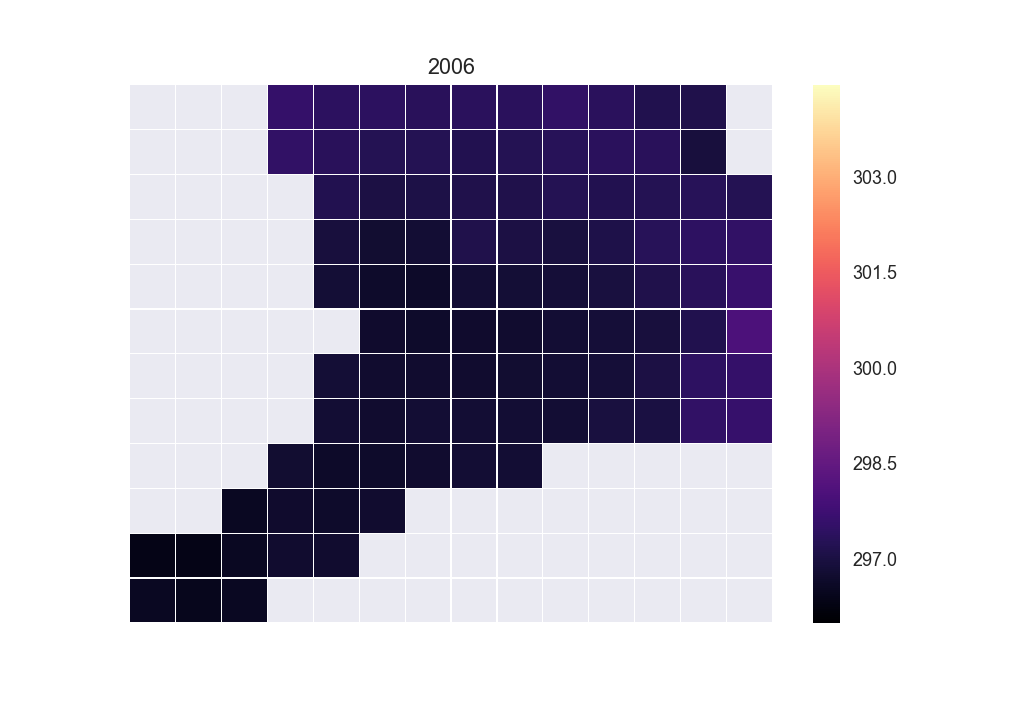

[[], []]

In [16]:
import seaborn as sns

fig = plt.figure()

heatmap_data = df['image'].iloc[0]

ax = sns.heatmap(
    heatmap_data,
    annot = False,
    vmin = data_min,
    vmax = data_max,
    cmap = 'magma',
    linewidths = 0.1,
)
ax.set_title(df.index[0].year)
ax.set(xticklabels=[], yticklabels=[])


### Animate the heatmap for multiple years

We will use the matplotlib animation module for this.

<IPython.core.display.Javascript object>


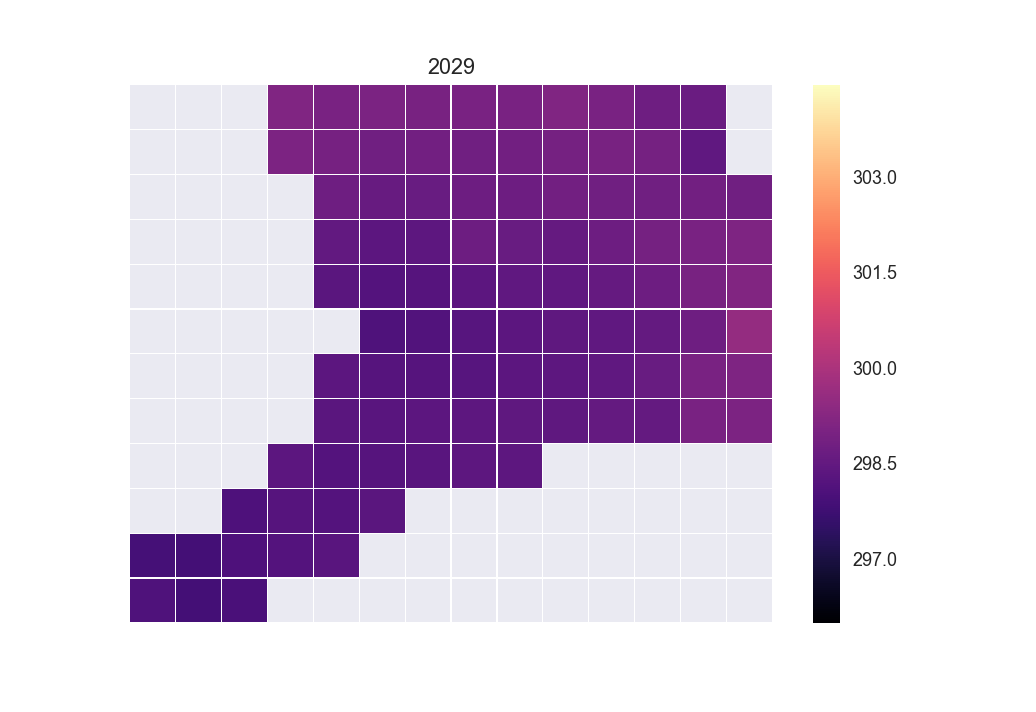

In [17]:
import matplotlib.animation as animation

# First set up the figure
fig_anim = plt.figure()

# The next piece is the animation function. It takes a single parameter, the frame number i
def update_frame(i):
    plt.clf()
    heatmap_data = df['image'].iloc[i]
    print(i)
    ax = sns.heatmap(
        heatmap_data,
        annot = False,
        vmin = data_min,
        vmax = data_max,
        cmap = 'magma',
        linewidths = 0.1,
    )
    ax.set_title(df.index[i].year)
    ax.set(xticklabels=[], yticklabels=[])

# Create the animation object
anim = animation.FuncAnimation(fig_anim, update_frame, interval=1000, blit=True)

More matplotlib [animation examples](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/).

Uncomment the next line to export the animation to a gif file. You can export to many other video formats. 

In [18]:
# anim.save('test.gif', writer="imagemagick")

_This tutorial was inspired by [this](https://medium.com/planet-os/querying-and-rendering-weather-data-with-python-72ac1938fc21) blog post from Planet OS_